In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


In [12]:
%%bash

[[ -e scores.h5 ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
[[ -e sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
[[ -e test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

In [13]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

In [17]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

n = 200
f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]][:n]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]][:n]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

In [40]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                revcomp=False)

TF-MoDISco is using the TensorFlow backend.


TypeError: object of type 'NoneType' has no len()

## Save and print the results

In [22]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

In [30]:
import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                revcomp=False)
grp = h5py.File("results.hdf5","r")
tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

metacluster idx 1
num seqlets 122
one hot
fwd


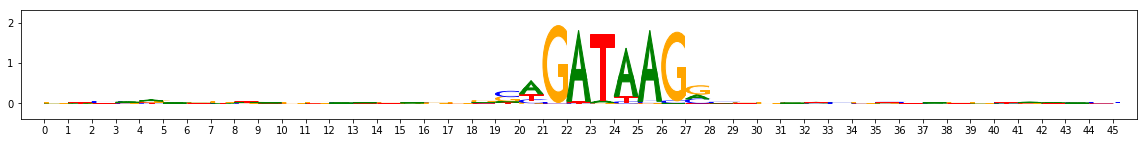

rev


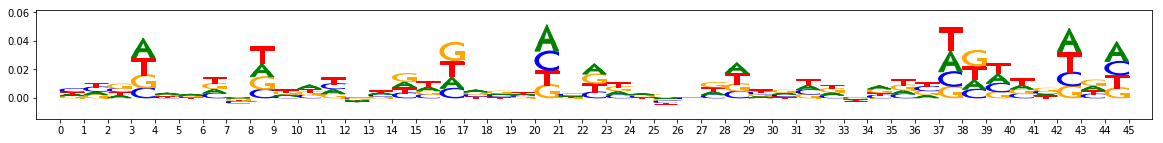

Task 0 hypothetical scores:
fwd


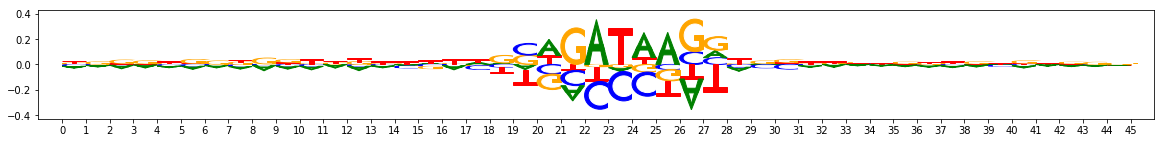

rev


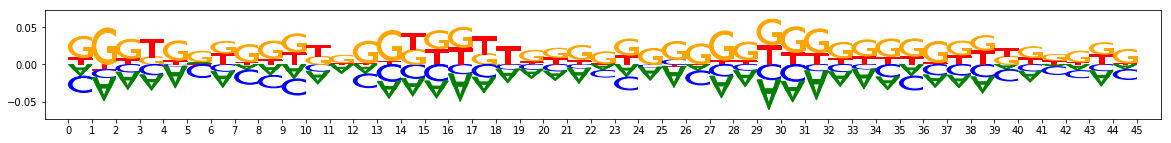

Task 0 actual importance scores:
fwd


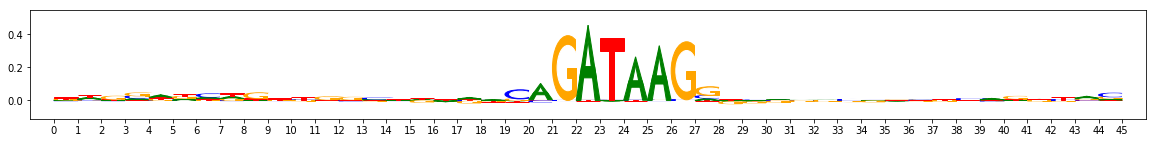

rev


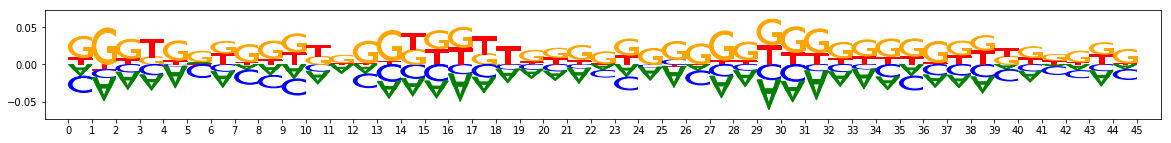

Task 1 hypothetical scores:
fwd


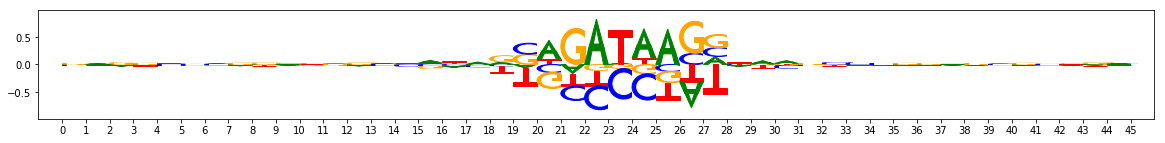

rev


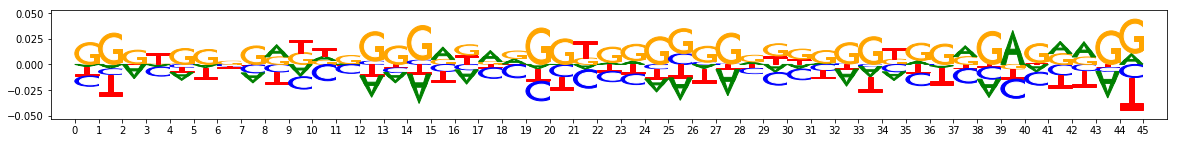

Task 1 actual importance scores:
fwd


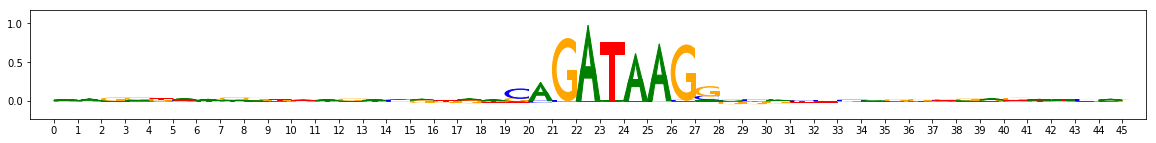

rev


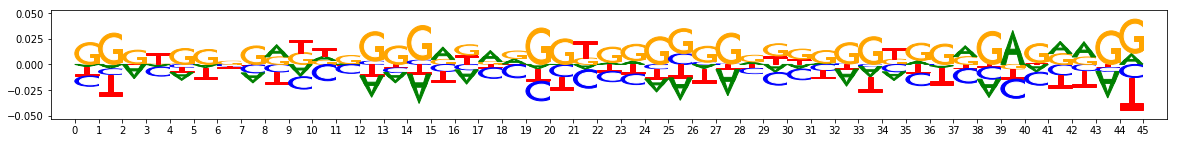

Task 2 hypothetical scores:
fwd


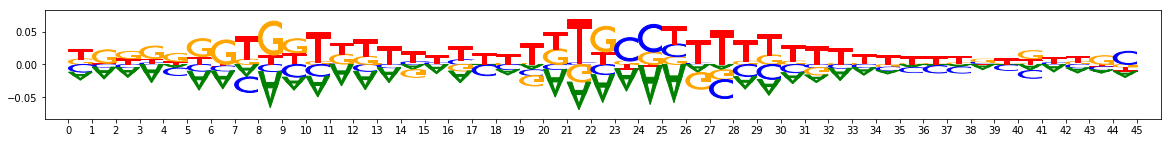

rev


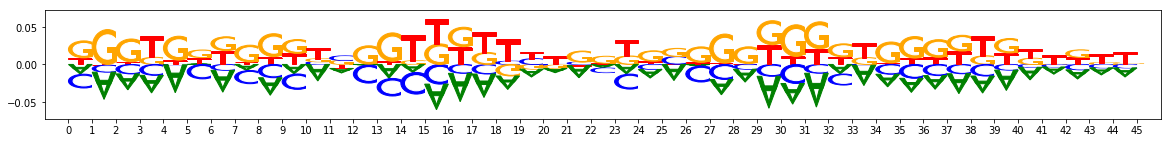

Task 2 actual importance scores:
fwd


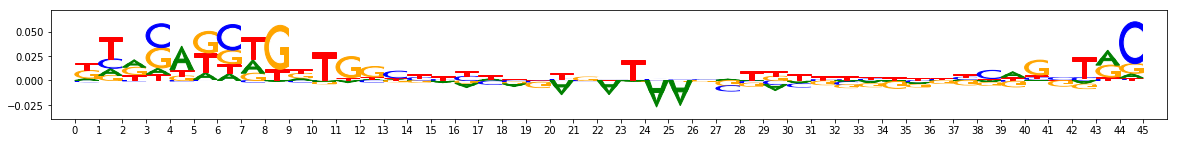

rev


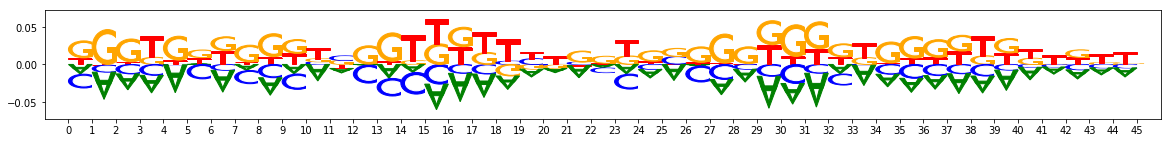

metacluster idx 0
num seqlets 110
one hot
fwd


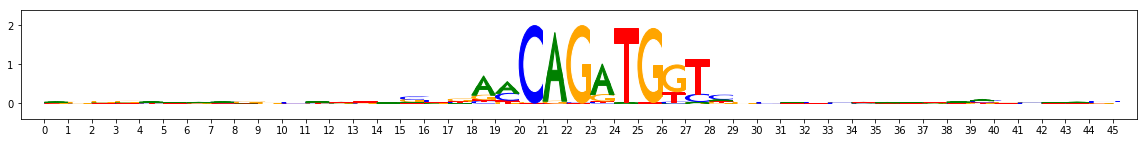

rev


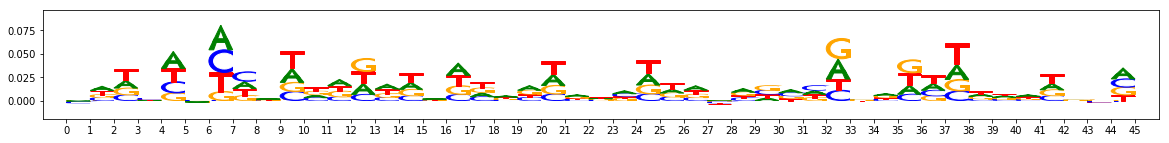

Task 0 hypothetical scores:
fwd


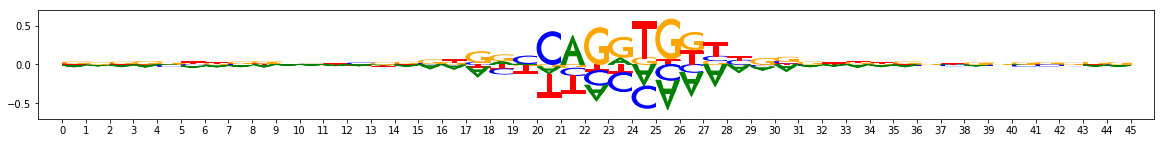

rev


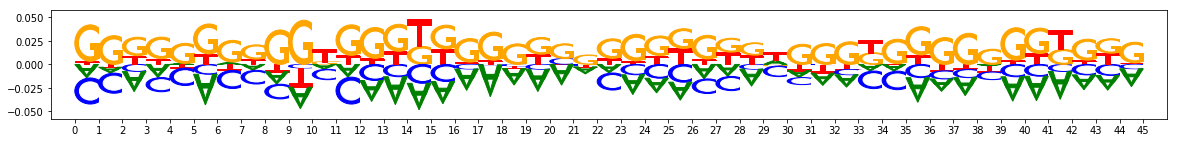

Task 0 actual importance scores:
fwd


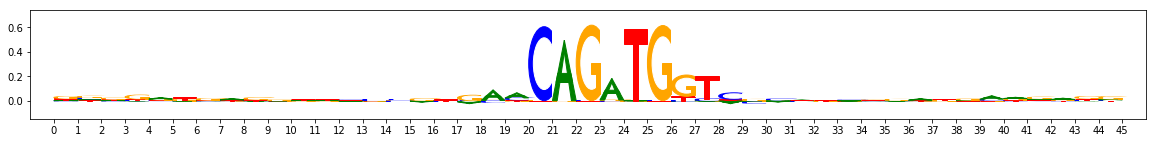

rev


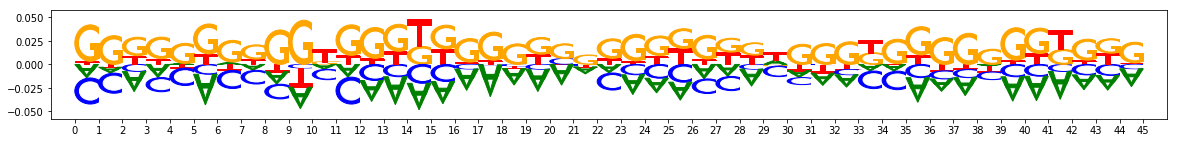

Task 1 hypothetical scores:
fwd


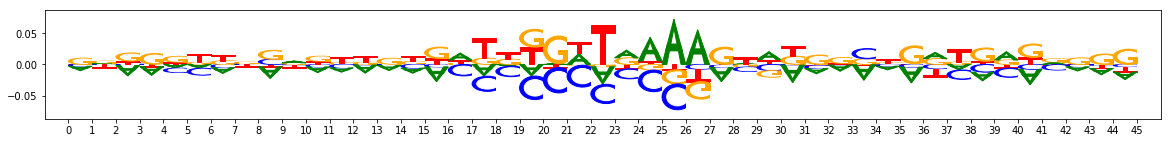

rev


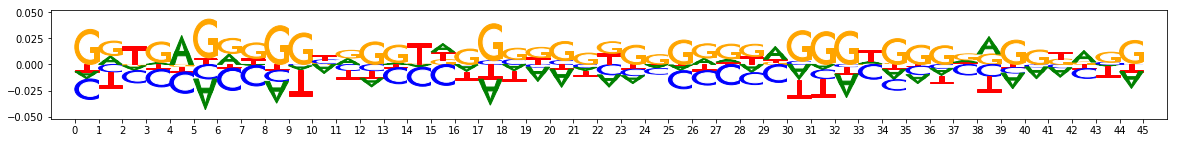

Task 1 actual importance scores:
fwd


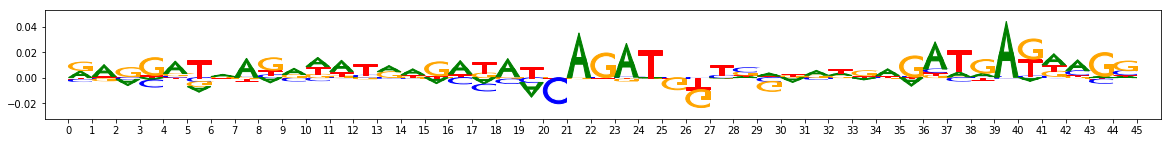

rev


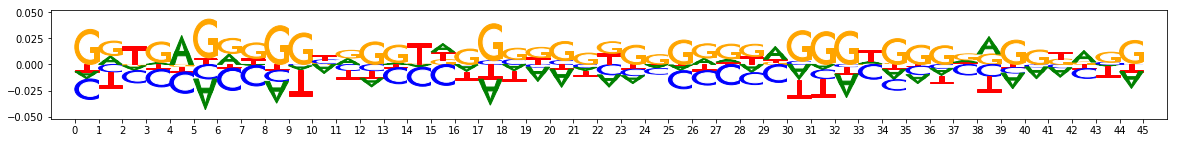

Task 2 hypothetical scores:
fwd


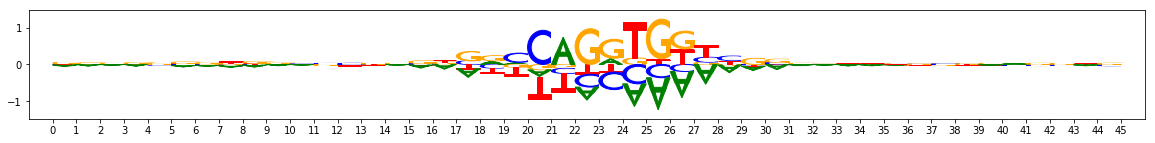

rev


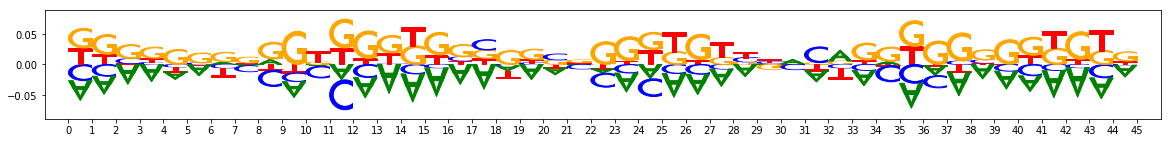

Task 2 actual importance scores:
fwd


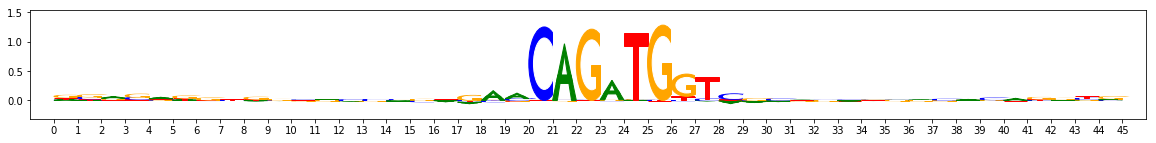

rev


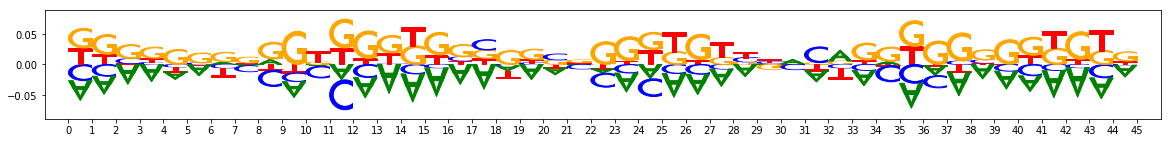

In [39]:
from modisco.visualization import viz_sequence
reload(viz_sequence)

for metacluster_idx in tfmodisco_results.metacluster_idx_to_submetacluster_results:
    print("metacluster idx", metacluster_idx)
    patterns = (tfmodisco_results
          .metacluster_idx_to_submetacluster_results[metacluster_idx]
          .seqlets_to_patterns_result.patterns)
    for pattern in patterns:
        print("num seqlets", len(pattern.seqlets))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        
        print("one hot")
        print("fwd")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].fwd),
                                                        background=background)) 
        print("rev")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].rev),
                                                        background=background)) 
        
        print("Task 0 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
        print("Task 0 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
        
        print("Task 1 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].rev)
        print("Task 1 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].rev)
        
        print("Task 2 hypothetical scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].rev)
        print("Task 2 actual importance scores:")
        print("fwd")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"].fwd)
        print("rev")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].rev)
        